In [6]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
#import statsmodels.formula.api as smf
import statsmodels.api as smf

%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

Question 1

In [4]:
d = pd.read_csv('Data/foxes.csv', sep=';')

d.head()

,group,avgfood,groupsize,area,weight
0,1,0.37,2,1.09,5.02
1,1,0.37,2,1.09,2.84
2,2,0.53,2,2.05,5.33
3,2,0.53,2,2.05,6.07
4,3,0.49,2,2.12,5.85


In [8]:
scaler = StandardScaler()
d = d.reindex( columns = d.columns.tolist() + ['F','G','A','W'])
d[['F','G','A','W']] = scaler.fit_transform(d[['avgfood','groupsize', 'area', 'weight']].to_numpy())

d.head()

,group,avgfood,groupsize,area,weight,F,G,A,W
0,1,0.37,2,1.09,5.02,-1.933180,-1.530701,-2.249313,0.415931
1,1,0.37,2,1.09,2.84,-1.933180,-1.530701,-2.249313,-1.433238
2,2,0.53,2,2.05,5.33,-1.122886,-1.530701,-1.210738,0.678887
3,2,0.53,2,2.05,6.07,-1.122886,-1.530701,-1.210738,1.306586
4,3,0.49,2,2.12,5.85,-1.325459,-1.530701,-1.135008,1.119973


Prior predictive simulation:

What should we expect from priors?

Positive association between area and food?
Postitive association between food and groupsize?
Negative association between weight and groupsize?

Does this lead to a positive association between area and weight?

In [48]:
N = int(1e4)

In [32]:
a1 = stats.norm.rvs(loc=0, scale=1, size=N)
a2 = stats.norm.rvs(loc=0, scale=1, size=N)
a3 = stats.norm.rvs(loc=0, scale=1, size=N)
bA = stats.lognorm.rvs(s=1, scale=np.exp(0), size=N)
bFG = stats.lognorm.rvs(s=1, scale=np.exp(0), size=N)
bFW = stats.lognorm.rvs(s=1, scale=np.exp(0), size=N)
bG = -stats.lognorm.rvs(s=1, scale=np.exp(0), size=N)

In [33]:
priorA = stats.norm.rvs(loc=0,scale=1,size=N)
priorF = stats.norm.rvs(loc=a1 + bA*A,scale=bA,size=N)
priorG = stats.norm.rvs(loc=a2 + bFG*F,scale=bFG,size=N)
priorW = stats.norm.rvs(loc=a3 + bFW*F + bG*G, scale=np.sqrt(bFW**2 + bG**2), size=N)

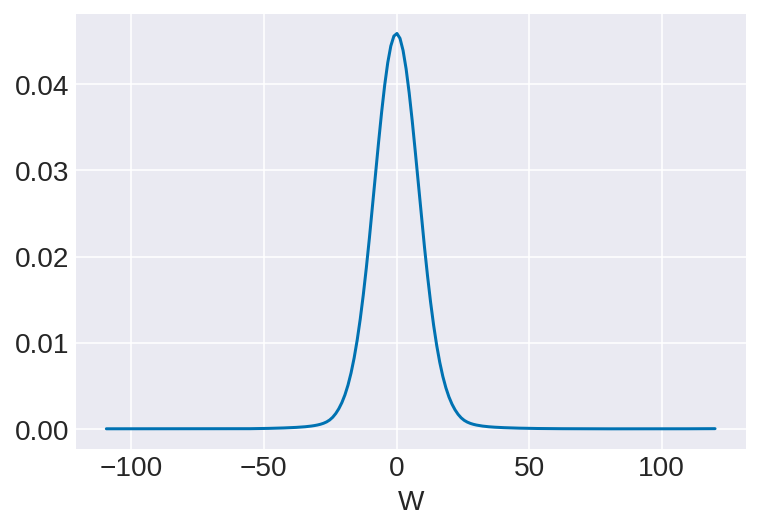

In [34]:
pm.kdeplot(priorW)
plt.xlabel('W', fontsize=14)
plt.yticks();

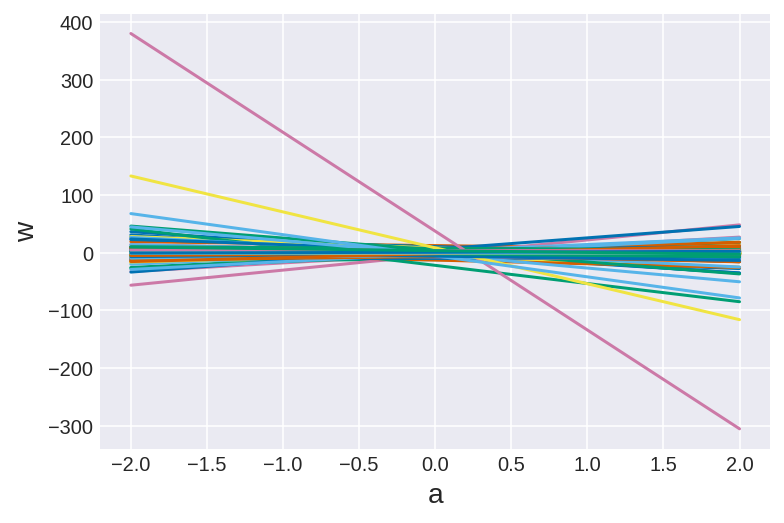

In [47]:
a = np.linspace(-2,2)

for i in range(200):
    idx = np.random.randint(N)
    f = a1[idx] + bA[idx]*a
    g = a2[idx] + bFG[idx]*f
    w = a3[idx] + bFW[idx]*f + bG[idx]*g
    plt.plot(a, w)
    
plt.xlabel('a', fontsize=14)
plt.ylabel('w', fontsize=14);

In [53]:
with pm.Model() as foxModel1:
    alpha = pm.Normal('alpha', mu=0, sd=1)
    beta = pm.Normal('beta', mu=0, sd=1)
    mu = pm.Deterministic('mu', alpha + beta * d.A)
    sigma = pm.Exponential('sigma', 1)
    W = pm.Normal('W', mu=mu, sd=sigma, observed=d.W)
    trace = pm.sample(10000, tune=1000)   

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:10<00:00, 2079.28draws/s]


/home/rer/anaconda3/envs/pymc3_resources/lib/python3.7/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


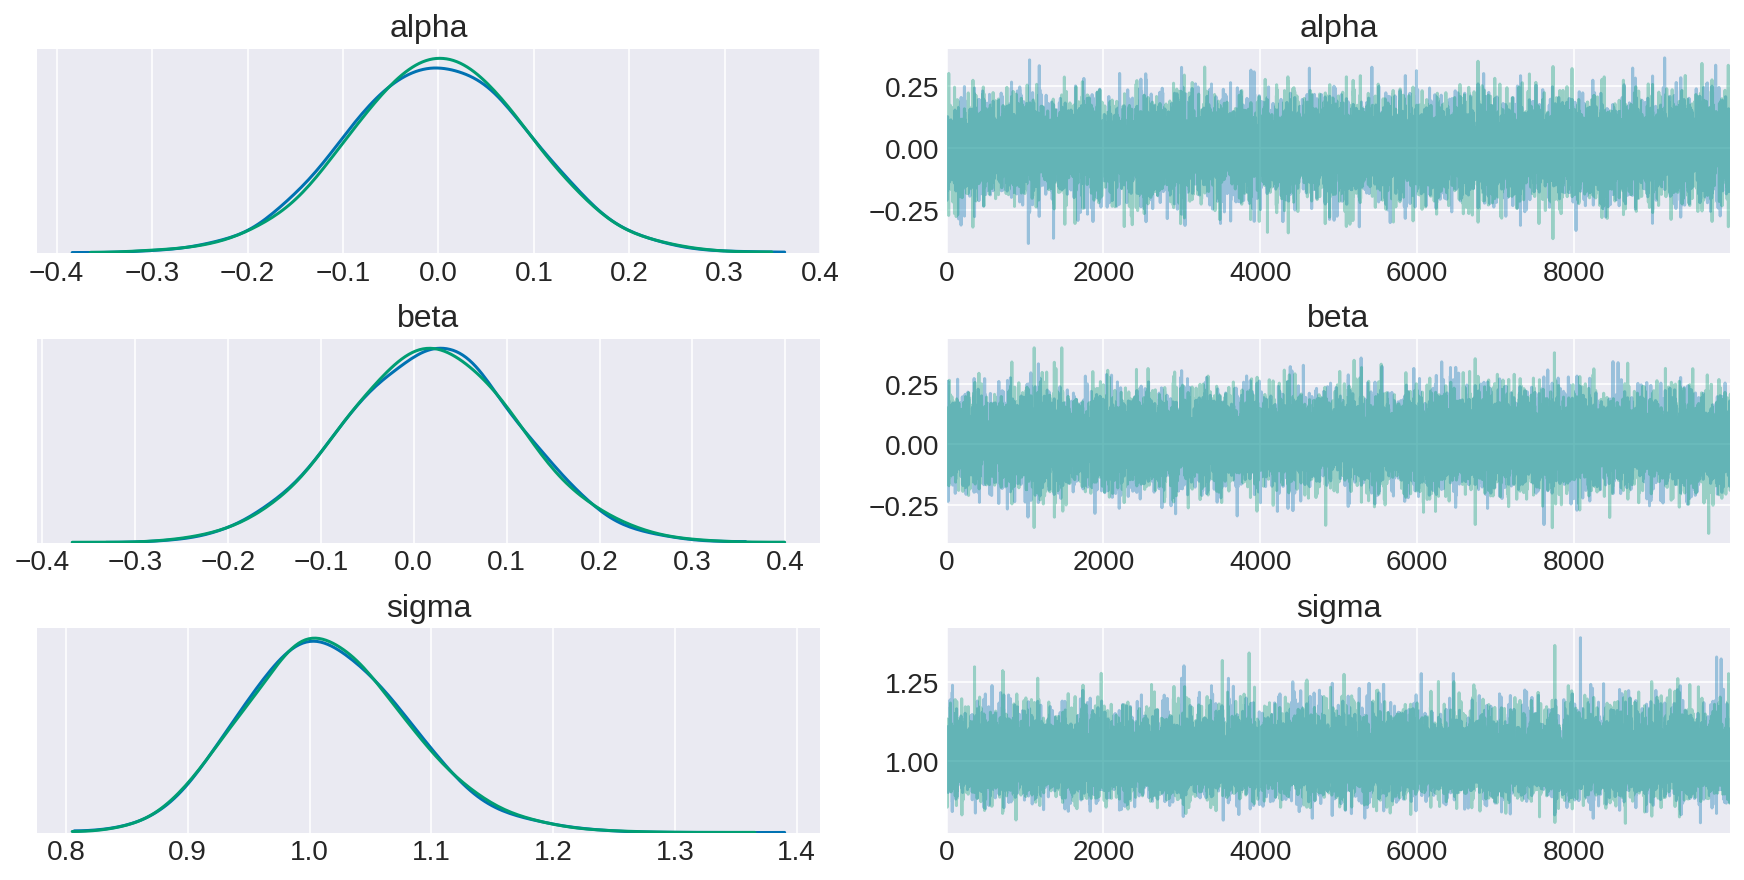

In [54]:
varnames = ['alpha', 'beta', 'sigma']
pm.traceplot(trace, varnames)

chain = trace[1000:]

In [57]:
pm.summary(chain, varnames, alpha=.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
alpha,0.00,0.09,0.0,-0.14,0.16,26920.55,1.0
beta,0.02,0.09,0.0,-0.13,0.17,26222.64,1.0
sigma,1.02,0.07,0.0,0.91,1.12,25994.65,1.0


In [59]:
with pm.Model() as foxModel1:
    alpha = pm.Normal('alpha', mu=0, sd=1)
    beta = pm.Normal('beta', mu=0, sd=1)
    mu = pm.Deterministic('mu', alpha + beta * d.area)
    sigma = pm.Exponential('sigma', 1)
    weight = pm.Normal('weight', mu=mu, sd=sigma, observed=d.weight)
    trace = pm.sample(10000, tune=1000)   

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:24<00:00, 897.58draws/s] 


/home/rer/anaconda3/envs/pymc3_resources/lib/python3.7/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


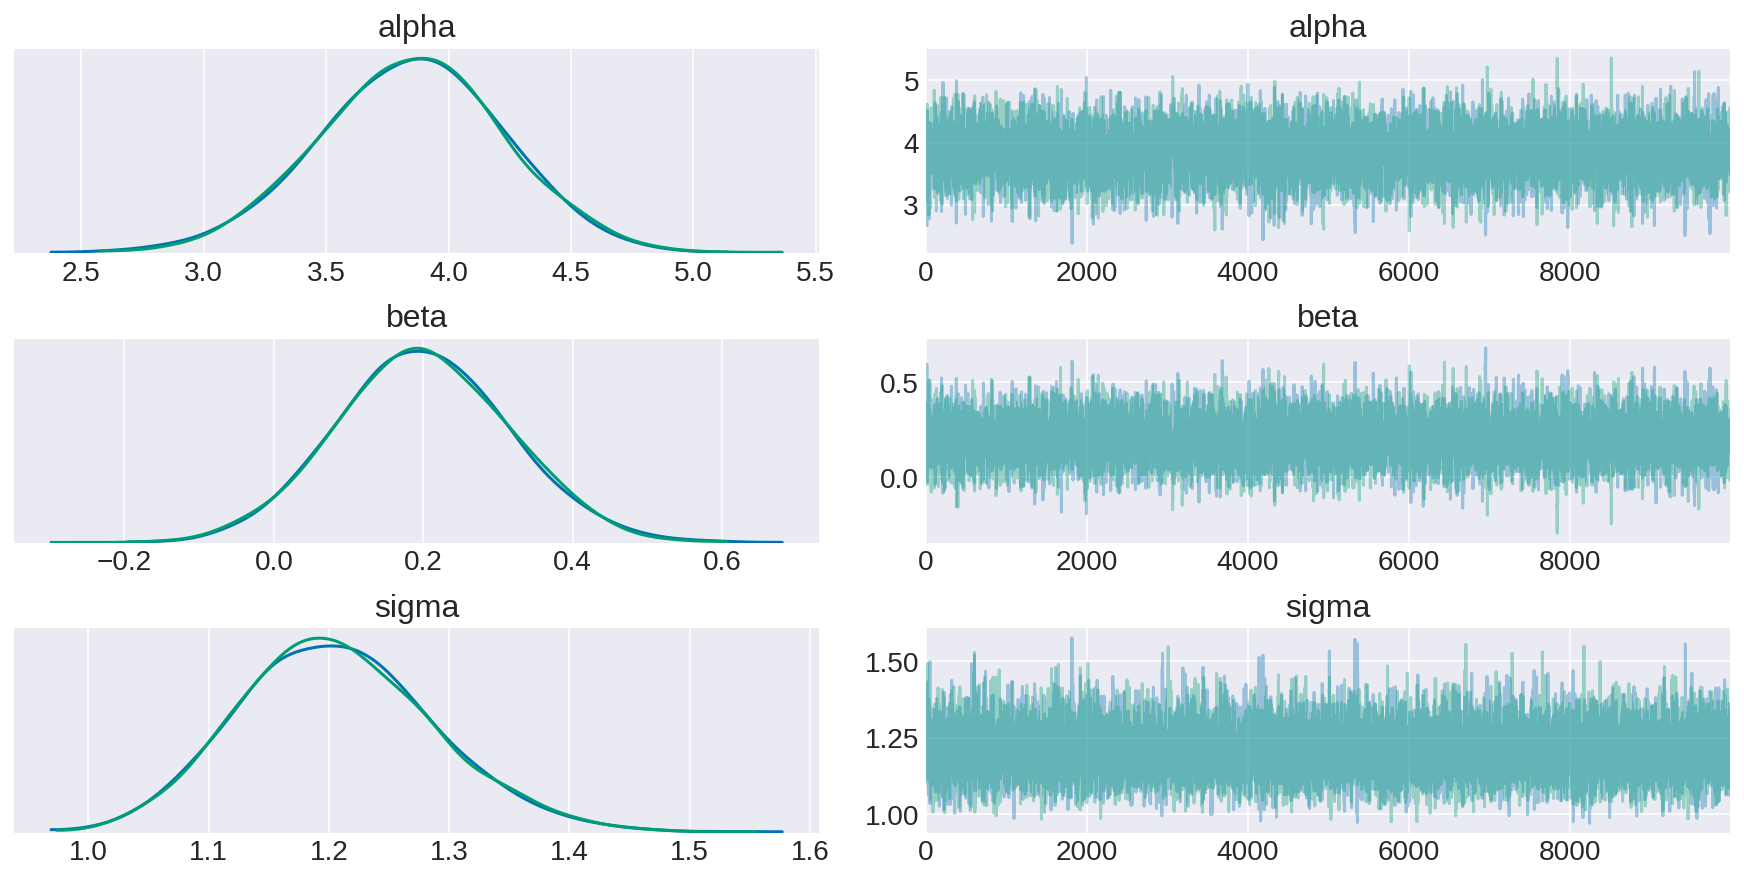

In [60]:
varnames = ['alpha', 'beta', 'sigma']
pm.traceplot(trace, varnames)

chain = trace[1000:]

In [61]:
pm.summary(chain, varnames, alpha=.11).round(2)

/home/rer/anaconda3/envs/pymc3_resources/lib/python3.7/site-packages/pymc3/stats.py:982: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
alpha,3.85,0.38,0.0,3.23,4.44,5871.50,1.0
beta,0.20,0.11,0.0,0.01,0.38,5916.84,1.0
sigma,1.21,0.08,0.0,1.08,1.34,8381.73,1.0
